<a href="https://colab.research.google.com/github/sg-peytrignet/geopython-2025/blob/main/4_cost_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Logo](https://www.itu.int/web/pp-18/assets/logo/itu_logo.png)

# Cost analysis

In this notebook, we will:

- Load the results from our previous exercises done on QGIS
- Asssess which technologies are feasible for each school
- Estimate the cost (CAPEX and OPEX) of connecting schools with each technology
- Select the option among those feasible that maximizes operator net revenue
- Display the costs and revenues for this solution
- Display the technology assignment results on a map

## Setting up our Python environment

We import Python libraries needed for our cost analysis:

- Computing libraries (`pandas`, `numpy`) for calculations
- GIS libraries (`geopandas`) for mapping
- Visualization libraries (`matplotlib`, `folium`, `seaborn`) for creating graphs and maps

These will help us analyze and visualize the costs of different connectivity options.

In [1]:
# Data handling
import pandas as pd
import numpy as np

# Graph and spatial libraries
import geopandas as gpd

# Visualization
import matplotlib.pyplot as plt
import folium
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# Notebook interaction and display
import ipywidgets as widgets
from IPython.display import display

## Set analysis parameters

We create an interactive interface to set important cost variables for different connection technologies (Fiber, Cellular, Point-to-Point, and Satellite).

For each technology, we can adjust:

- **CAPEX**: One-time installation costs (equipment, setup) in USD
- **OPEX**: Ongoing yearly costs (maintenance, service fees) in USD
- **ARPU**: Annual Revenue Per User (expected income per person) in USD

We also set the **maximum fiber cable length** per school and **analysis timeframe** in years.

**Estimating Number of Users:**

- In our case, the number of users is the number of pupils who will access the internet at each school.
- First, we count the number of residents living within each school's radius (see figure).
- Then, we multiply the number of residents by the percentage of school-age population.

This gives us our estimated number of users per 100 residents in a radius around each school.

_Table. Number of internet users in Sao Tome and Principe._

| Metric | Value | Source |
|--------|--------|---------|
| Population of School Age (%) | 15.74 | [UNESCO](https://data.uis.unesco.org/index.aspx?queryid=3847) |
| Users per 100 Residents | 15.74 | - |

_Figure. 1km buffers around schools overlaid with population data._

<a href="https://ibb.co/dB09sHB"><img src="https://i.ibb.co/9n9Xmdn/demand-buffers.jpg" alt="demand-buffers" border="0"></a>

**Estimating Annual Revenue per User (ARPU):**

- Start with the monthly cost of an appropriate data bundle.
- Multiply by the number of school months in the year.

A note about operator revenues:

- We use mobile internet costs as our baseline.
- This is because mobile cost data *per user* is widely available.

_Table. Operator revenues in Sao Tome and Principe._

| Metric | Value | Source |
|--------|--------|---------|
| Monthly Cost of 15GB Data (USD) | 25.00 | [Mobile Telecommunications Company (MTC)](https://mtc.com.na/contract/databundle/1506) |
| School Year Duration (months) | 9.00 | Education System Data |
| Annual Revenue Per User (USD) | 225 |  |

In [24]:
# @title Cost parameters
# Common layout for all widgets
# Custom Styling
box_style = "background-color: #f9f9f9; padding: 10px; border-radius: 10px; margin-bottom: 10px;"
title_style = "font-size:16px; font-weight:bold; color:#444;"

# Common Layout for all widgets
item_layout = widgets.Layout(width='95%', flex='1 1 auto')

# Parameters for each technology
technologies = ['fiber', 'p2area', 'p2p', 'satellite']
tech_controls = {}

for tech in technologies:
    tech_controls[tech] = {
        'CAPEX': widgets.FloatSlider(
            description='CAPEX (USD):',
            min=0, max=10000, step=1, value=1000,
            layout=item_layout, style={'description_width': 'initial'}, readout_format=',.0f'
        ),
        'OPEX': widgets.FloatSlider(
            description='OPEX (USD):',
            min=0, max=5000, step=1, value=500,
            layout=item_layout, style={'description_width': 'initial'}, readout_format=',.0f'
        ),
        'ARPU': widgets.FloatSlider(
            description='ARPU (USD):',
            min=0, max=500, step=1, value=225,
            layout=item_layout, style={'description_width': 'initial'}, readout_format=',.0f'
        )
    }

    # Add max fiber length parameter only to Fiber
    if tech == 'fiber':  # FIX: Corrected case sensitivity
        tech_controls[tech]['max_length'] = widgets.FloatSlider(
            description='Max Fiber Length (km):',
            min=0, max=50, step=1, value=25,
            layout=item_layout, style={'description_width': 'initial'}, readout_format=',.0f'
        )

# Overall parameters
num_years = widgets.IntSlider(
    description='Number of years:', min=1, max=50, step=1, value=10,
    layout=item_layout, style={'description_width': 'initial'}, readout_format=',.0f'
)

users_per_pop = widgets.FloatSlider(
    description='Users per 100 residents:', min=0, max=100, step=1, value=16,
    layout=item_layout, style={'description_width': 'initial'}, readout_format=',.3f'
)

# Arrange controls in a visually appealing layout
tech_layouts = []
for tech, controls in tech_controls.items():
    tech_layouts.append(
        widgets.VBox(
            [widgets.HTML(value=f"<div style='{title_style}'>{tech.capitalize()}</div>")] +
            [controls[param] for param in controls],
            layout=widgets.Layout(
                border='solid 1px #ddd', padding='10px', margin='5px',
                background='#f5f5f5', border_radius='8px'
            )
        )
    )

overall_layout = widgets.VBox(
    [widgets.HTML(value=f"<div style='{title_style}'>Overall Parameters</div>"), num_years, users_per_pop],
    layout=widgets.Layout(padding='10px', margin='5px', background='#f0f0f0', border_radius='8px')
)

# Use Tabs for better organization
tab = widgets.Tab()
tab.children = [overall_layout] + tech_layouts
for i, title in enumerate(["Overall"] + [t.capitalize() for t in technologies]):
    tab.set_title(i, title)

# Set default values
tech_controls['satellite']['CAPEX'].value = 8000  # High one-time cost
tech_controls['satellite']['OPEX'].value = 4000   # High annual maintenance

tech_controls['p2p']['CAPEX'].value = 2000
tech_controls['p2p']['OPEX'].value = 800

tech_controls['p2area']['CAPEX'].value = 1500   # Slightly cheaper than P2P
tech_controls['p2area']['OPEX'].value = 600     # Slightly cheaper than P2P

tech_controls['fiber']['CAPEX'].value = 4000      # Medium one-time cost
tech_controls['fiber']['OPEX'].value = 2000       # Medium annual maintenance

# Convert to scalars
user_ratio = users_per_pop.value / 100
years = num_years.value
fiber_max_length = tech_controls['fiber']['max_length'].value
fiber_arpu = tech_controls['fiber']['ARPU'].value
p2area_arpu = tech_controls['p2area']['ARPU'].value
p2p_arpu = tech_controls['p2p']['ARPU'].value
satellite_arpu = tech_controls['satellite']['ARPU'].value
fiber_capex = tech_controls['fiber']['CAPEX'].value
p2area_capex = tech_controls['p2area']['CAPEX'].value
p2p_capex = tech_controls['p2p']['CAPEX'].value
satellite_capex = tech_controls['satellite']['CAPEX'].value
fiber_opex = tech_controls['fiber']['OPEX'].value
p2area_opex = tech_controls['p2area']['OPEX'].value
p2p_opex = tech_controls['p2p']['OPEX'].value
satellite_opex = tech_controls['satellite']['OPEX'].value

# Display the tab layout
display(tab)

## Import files

### Results from previous analyses

We load our previously calculated analysis results:

- **Proximity data**: distances to existing infrastructure
- **Coverage data**: which areas have cellular service
- **Demand data**: number of potential users near each school
- **Visibility data**: line-of-sight between schools and towers
- **Fiber path data**: distance between schools and fiber nodes

This gives us the foundation for our revenue and cost calculations.

In [3]:
# STEP 1: Load results from previous analyses using Geopandas
# The file contains the proximity, coverage, demand, fiber path and visibility analyses
merged_results = gpd.read_file("https://zstagigaprodeuw1.blob.core.windows.net/gigainframapkit-public-container/stp/outputs/merged_results.geojson")

# STEP 2: Set up the table to use school_id as the main identifier
merged_results = merged_results.set_index("school_id")

# STEP 3: Show the first few rows of data to check what we loaded
merged_results.head()

,cell_site_distance,fiber_node_distance,coverage,population_1km,visible,geometry
school_id,,,,,,
1,223505.892325,392.462504,True,2643.301395,False,POINT (16.86548 -24.62704)
2,789.912802,209.967957,True,4623.873197,True,POINT (17.07466 -22.59953)
3,141006.662606,2178.090670,False,53.916444,False,POINT (16.0606 -20.15091)
4,542.425612,319.117857,True,83.437086,True,POINT (17.06546 -22.54665)
5,107.142936,83.408131,True,270.790799,True,POINT (17.10974 -22.57598)


In [ ]:
# We can inspect the data types in the dataframe
# cell_site_distance, fiber_node_distance and population_1km are float64 (numerical)
# coverage and visible are bool (`True` or `False`)
# geometry is geometry (a geospatial column type)
merged_results.dtypes

In [ ]:
# To select column 'coverage', use square brackets
merged_results['coverage']

In [ ]:
# To select the row for school 1, use .loc and square bracketswith the index
merged_results.loc[1]

<Axes: >

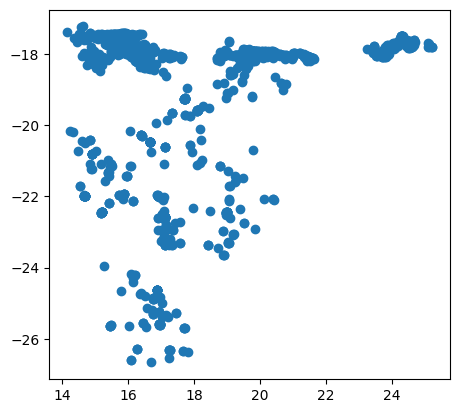

In [4]:
# We can quickly plot the merged_results GeoDataFrame to see the locations of schools using the plot() method
merged_results.plot()

In [5]:
# We also load the 4G coverage contours again, so we can display them later on
coverage_4G = gpd.read_file("https://zstagigaprodeuw1.blob.core.windows.net/gigainframapkit-public-container/namibia/NAM_4G_coverage.geojson")

## Assess feasibility of technologies for each school

We determine which connection technologies are possible for each school based on:

- **Fiber**: Is it close enough to existing fiber networks?
- **Cellular**: Is it in an area with coverage?
- **Point-to-Point**: Does it have line-of-sight to towers?
- **Satellite**: Always feasible, but often more expensive.

This helps eliminate impossible options before cost analysis.

In [6]:
# Create a new table to track which technologies are possible for each school
feasibility = merged_results.copy()

# Check if FIBER is possible:
# Create a boolean column (True/False) based on the distance to the nearest fiber node
feasibility["fiber_feasible"] = feasibility["fiber_node_distance"] <= fiber_max_length*1000

# Check if CELLULAR (P2AREA) is possible:
# Use existing coverage information (True/False)
feasibility["p2area_feasible"] = feasibility["coverage"]

# Check if POINT-TO-POINT (P2P) is possible:
# Use existing line-of-sight visibility information (True/False)
feasibility["p2p_feasible"] = feasibility["visible"]

# Check if SATELLITE is possible:
# Satellite is always feasible since it works everywhere
feasibility["satellite_feasible"] = True

# Keep only the columns that show what's feasible
feasibility = feasibility[["fiber_feasible",
                          "p2area_feasible",
                          "p2p_feasible",
                          "satellite_feasible"]]

In [7]:
# Display feasibility, showing the first few rows
# We have four boolean (True/False) columns, one for each technology
feasibility.head()

,fiber_feasible,p2area_feasible,p2p_feasible,satellite_feasible
school_id,,,,
1,True,True,False,True
2,True,True,True,True
3,True,False,False,True
4,True,True,True,True
5,True,True,True,True


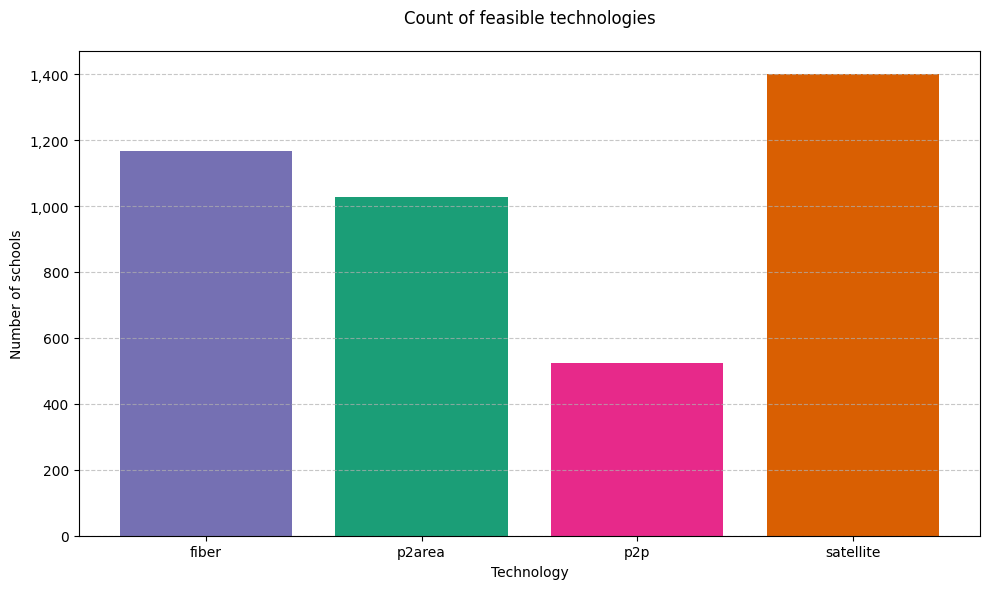

In [8]:
# @title Figure: Technology Feasibility
# Create feasibility counts for bar chart
feasibility_counts = {
   'fiber': feasibility['fiber_feasible'].sum(),
   'p2area': feasibility['p2area_feasible'].sum(),
   'p2p': feasibility['p2p_feasible'].sum(),
   'satellite': feasibility['satellite_feasible'].sum()
}
color_map = {
   'p2area': '#1b9e77',
   'satellite': '#d95f02',
   'fiber': '#7570b3',
   'p2p': '#e7298a',
   'unconnected': '#bababa'
}
plt.figure(figsize=(10, 6))
technologies = list(feasibility_counts.keys())
counts = list(feasibility_counts.values())
colors = [color_map[tech] for tech in technologies]
plt.bar(technologies, counts, color=colors)
plt.title('Count of feasible technologies', pad=20)
plt.xlabel('Technology')
plt.ylabel('Number of schools')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
plt.tight_layout()

## Compute operator revenues for each school and technology

For each feasible technology at each school, we calculate the potential revenue. This shows which technologies might be profitable for service providers - as summarised in the figure below.


_Figure. Net revenue._

<a href="https://ibb.co/3sy1qTr"><img src="https://i.ibb.co/LPzSW0k/net-revenues.jpg" alt="net-revenues" border="0"></a>

In [26]:
# Make a fresh copy of our results table to store revenue calculations
net_revenues = merged_results.copy()

# FIBER CALCULATIONS
  # Calculate yearly revenue: monthly fee × number of users (population × users per 100 residents)
fiber_annual_revenue = fiber_arpu * merged_results["population_1km"] * user_ratio
  # Calculate total costs: one-time setup cost + (yearly OPEX × number of years)
fiber_total_costs = fiber_capex + fiber_opex * years
  # Calculate profit: (yearly revenue × number of years) - total costs
net_revenues["fiber_net_revenue"] = fiber_annual_revenue * years - fiber_total_costs

# CELLULAR (P2AREA) CALCULATIONS
cellular_annual_revenue = p2area_arpu * merged_results["population_1km"] * user_ratio
cellular_total_costs = p2area_capex + p2area_opex * years
net_revenues["p2area_net_revenue"] = cellular_annual_revenue * years - cellular_total_costs

# POINT-TO-POINT (P2P) CALCULATIONS
p2p_annual_revenue = p2p_arpu * merged_results["population_1km"] * user_ratio
p2p_total_costs = p2p_capex + p2p_opex * years
net_revenues["p2p_net_revenue"] = p2p_annual_revenue * years - p2p_total_costs

# SATELLITE CALCULATIONS
satellite_annual_revenue = satellite_arpu * merged_results["population_1km"] * user_ratio
satellite_total_costs = satellite_capex + satellite_opex * years
net_revenues["satellite_net_revenue"] = satellite_annual_revenue * years - satellite_total_costs

# Keep only the columns showing profit/loss for each technology
net_revenues = net_revenues[["fiber_net_revenue", "p2area_net_revenue",
                           "p2p_net_revenue", "satellite_net_revenue"]]

In [10]:
# Create a summary table showing costs for each technology
costs = pd.DataFrame({
    'technology': ['fiber', 'p2area', 'p2p', 'satellite'],
    'total_cost': [fiber_total_costs, cellular_total_costs,
                   p2p_total_costs, satellite_total_costs]
})
# Add a column showing yearly cost (total cost divided by number of years)
costs["annual_cost"] = costs["total_cost"] / years

# Set cost to missing if technology is not feasible
for tech in ['fiber', 'p2area', 'p2p', 'satellite']:
    net_revenues.loc[~feasibility[f'{tech}_feasible'], f'{tech}_net_revenue'] = np.nan

In [11]:
# Display costs
# Here, fiber cost does not vary by length of fiber required
costs

,technology,total_cost,annual_cost
0,fiber,24000.0,2400.0
1,p2area,7500.0,750.0
2,p2p,10000.0,1000.0
3,satellite,48000.0,4800.0


First, we compare the annual costs (CAPEX and OPEX) for the different technologies.

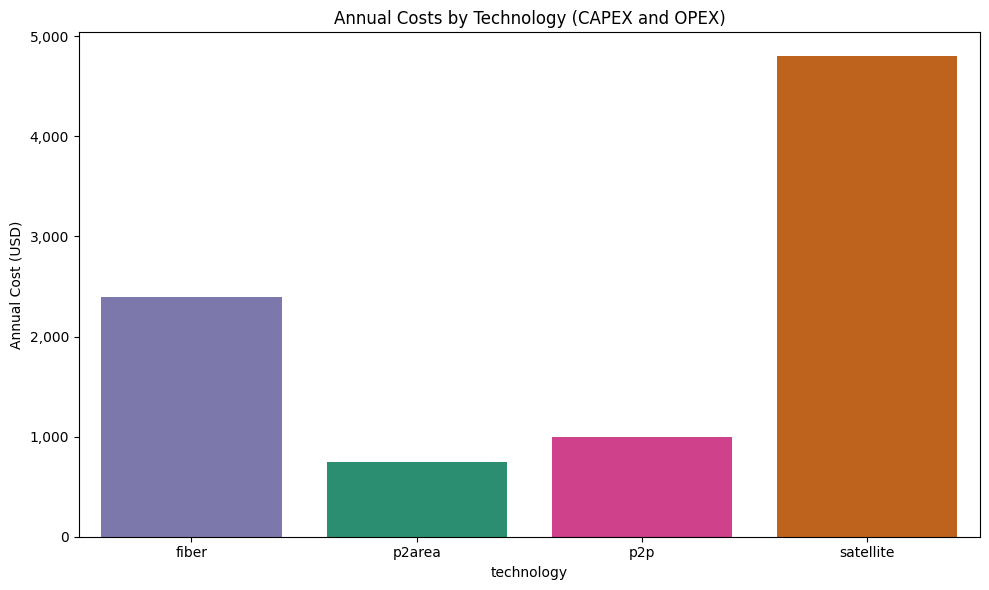

In [12]:
# @title Figure: annual costs per school
# Calculate total cost per school for each technology

# Create the plot
plt.figure(figsize=(10, 6))
sns.barplot(data=costs,
            x='technology',
            y='annual_cost',
            hue='technology',
            legend=False,
            palette=color_map)

plt.title(f'Annual Costs by Technology (CAPEX and OPEX)')
plt.ylabel('Annual Cost (USD)')
plt.xticks(rotation=0)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
plt.tight_layout()
plt.show()

Then, we compare the revenues associated with each school and technology pair. In this chart below, each dot represents a profit for a school and the bar is the median. Within each technology, schools with a higher number of users have a higher revenue and schools where the technology is not feasible do not appear in the chart.

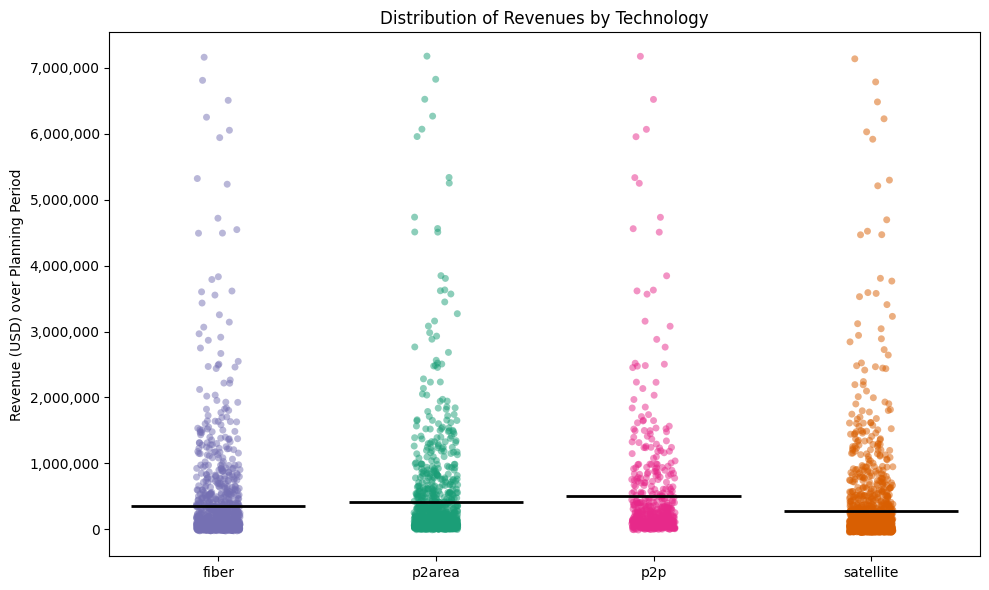

In [13]:
# @title Figure: Net Revenues by Technology
# Box plot of net revenues by technology
data = net_revenues[['fiber_net_revenue', 'p2area_net_revenue', 'p2p_net_revenue', 'satellite_net_revenue']].melt(
   var_name='Technology',
   value_name='Revenue'
)
data['Technology'] = data['Technology'].str.replace('_net_revenue', '')
plt.figure(figsize=(10, 6))
sns.boxplot(x='Technology', y='Revenue', data=data, palette=color_map, hue='Technology',
            showfliers=False, showbox=False, showcaps=False, showmeans=True, meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10)

sns.stripplot(x='Technology', y='Revenue', data=data, alpha=0.5, jitter=True, palette=color_map, hue='Technology')
plt.xlabel('')
plt.ylabel('Net Revenue (USD) over Planning Period')
plt.title('Distribution of Net Revenues by Technology')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.tight_layout()
plt.show()

## Assign a technology to each school by maximizing operator revenue

We assign the best technology for each school by:

1. Considering **only feasible** options.
2. Among the feasible options, selecting the technology with **highest net revenue**.
3. Marking schools where no options exist as **unconnected**.

This helps identify the most economically viable connection method for each school.

In [14]:
# STEP 1: Find the most profitable technology for each school
# List all our revenue columns for each technology
revenue_cols = ['fiber_net_revenue', 'p2area_net_revenue',
                'p2p_net_revenue', 'satellite_net_revenue']

# For each school, find which technology gives the highest revenue
# The idxmax function returns the column name with the highest value
# Then we clean up the column by removing '_net_revenue' from the end
net_revenues['technology'] = net_revenues[revenue_cols].idxmax(axis=1).str.replace('_net_revenue', '')

# STEP 2: Handle schools with no viable options
# Check which schools have no revenue data at all (all values are missing)
mask = net_revenues[revenue_cols].isna().all(axis=1)
# For these schools, mark them as "unconnected"
net_revenues.loc[mask, 'technology'] = "unconnected"

# STEP 3: Add cost information for each school's selected technology, so everything is in the same table
# First reset the index to make school_id a regular column
# Then merge with costs table based on the selected technology
# Finally, put school_id back as the index
net_revenues = pd.merge(net_revenues.reset_index(),
                       costs,
                       on='technology',
                       how='left').set_index("school_id")

In [15]:
# Display net revenues again, this time with technology selection
net_revenues.head()

,fiber_net_revenue,p2area_net_revenue,p2p_net_revenue,satellite_net_revenue,technology,total_cost,annual_cost
school_id,,,,,,,
1,9.275885e+05,9.440885e+05,NaN,9.035885e+05,p2area,7500.0,750.0
2,1.640594e+06,1.657094e+06,1.654594e+06,1.616594e+06,p2area,7500.0,750.0
3,-4.590080e+03,NaN,NaN,-2.859008e+04,fiber,24000.0,2400.0
4,6.037351e+03,2.253735e+04,2.003735e+04,-1.796265e+04,p2area,7500.0,750.0
5,7.348469e+04,8.998469e+04,8.748469e+04,4.948469e+04,p2area,7500.0,750.0


## Visualize the technology assignment

We create two main visualizations:

1. **Bar Chart**: Shows how many schools are assigned to each technology
2. **Interactive Map**: Displays schools color-coded by their assigned technology

### Bar chart

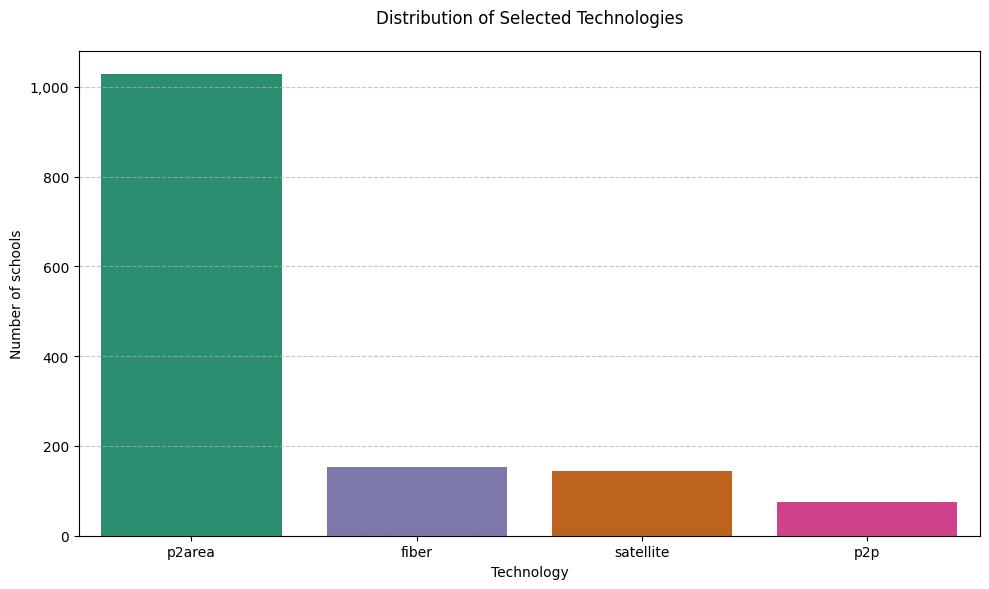

In [16]:
# @title Figure: Distribution of Selected Technologies
plt.figure(figsize=(10, 6))
sns.barplot(data=net_revenues["technology"].value_counts().reset_index(),
           x="technology",
           y="count",
           palette=color_map,
           hue="technology")
plt.title('Distribution of Selected Technologies', pad=20)
plt.xlabel('Technology')
plt.ylabel('Number of schools')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
plt.tight_layout()

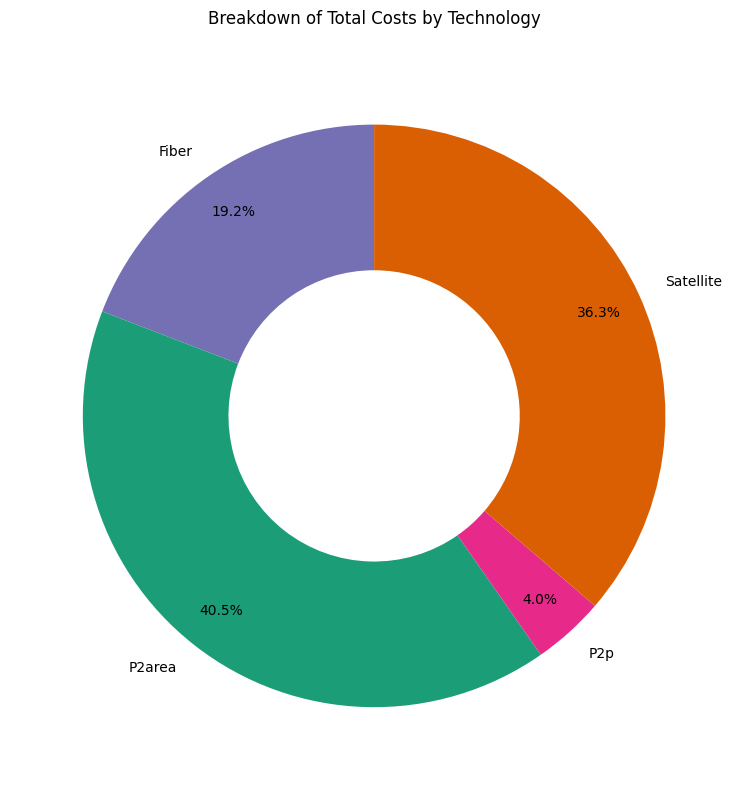

In [17]:
# @title Figure: Breakdown of Total Costs
plt.figure(figsize=(10, 8))
cost_data = net_revenues.groupby("technology")["total_cost"].sum()
plt.pie(cost_data,
        labels=[tech.capitalize() for tech in cost_data.index],
        colors=[color_map[tech] for tech in cost_data.index],
        autopct='%1.1f%%',
        startangle=90,
        pctdistance=0.85,
        wedgeprops=dict(width=0.5))
plt.title('Breakdown of Total Costs by Technology', pad=20)
plt.tight_layout()

### Map

In [18]:
# @title Figure: Interactive Map
def plot_points_by_technology(points_gdf, color_map, coverage_gdf=None, title="Points by Technology", zoom=6):
    """
    Create an interactive map with points colored by selected technology and optional 4G coverage
    """
    if points_gdf.crs != "EPSG:4326":
        points_gdf = points_gdf.to_crs("EPSG:4326")

    center_lat = points_gdf.geometry.y.mean()
    center_lon = points_gdf.geometry.x.mean()
    m = folium.Map(location=[center_lat, center_lon], zoom_start=zoom)

    # Add 4G coverage layer if provided
    if coverage_gdf is not None:
        if coverage_gdf.crs != "EPSG:4326":
            coverage_gdf = coverage_gdf.to_crs("EPSG:4326")

        coverage_group = folium.FeatureGroup(name="4G Coverage")

        folium.GeoJson(
            coverage_gdf,
            style_function=lambda x: {
                'fillColor': '#4287f5',
                'fillOpacity': 0.2,
                'color': '#2664ba',
                'weight': 1
            }
        ).add_to(coverage_group)

        coverage_group.add_to(m)

    title_html = f'''
    <div style="position: fixed;
                top: 10px;
                left: 50px;
                z-index: 1000;
                background-color: white;
                padding: 10px;
                border-radius: 5px;">
        <h4>{title}</h4>
        Total Points: {len(points_gdf)}
    </div>
    '''

    # Modified legend with separate sections
    legend_html = '''
    <div style="position: fixed;
                bottom: 50px;
                right: 50px;
                z-index: 1000;
                background-color: white;
                padding: 10px;
                border-radius: 5px;">
    '''

    # Schools section
    legend_html += '<p><strong>Schools by Technology</strong></p>'
    for tech, color in color_map.items():
        legend_html += f'<p><span style="color:{color}">●</span> {tech}</p>'

    # Coverage section if provided
    if coverage_gdf is not None:
        legend_html += '<hr style="margin: 10px 0;">'  # Separator line
        legend_html += '<p><strong>Network Coverage</strong></p>'
        legend_html += f'<p><span style="color:#4287f5">■</span> 4G Coverage</p>'

    legend_html += '</div>'

    m.get_root().html.add_child(folium.Element(title_html))
    m.get_root().html.add_child(folium.Element(legend_html))

    points_group = folium.FeatureGroup(name="Schools")

    for _, row in points_gdf.iterrows():
        color = color_map.get(row.technology, '#808080')  # gray for NaN
        folium.CircleMarker(
            location=[row.geometry.y, row.geometry.x],
            radius=5,
            color='black',
            weight=1,
            fill=True,
            fill_color=color,
            fill_opacity=0.7,
            popup=f"ID: {row.name}<br>Technology: {row.technology}"
        ).add_to(points_group)

    points_group.add_to(m)

    # Add layer control
    folium.LayerControl().add_to(m)

    return m

In [19]:
# Combine our main results table with the selected technology for each school
# 1. Start with merged_results (our main table with school information)
# 2. Add the "technology" column, which is the result of technology selection
# 3. Keep only schools where we were able to select a technology (remove rows where technology is missing)
technology_selection = (merged_results
                       .merge(net_revenues["technology"],
                             left_index=True,  # Use index (school_id) to match rows
                             right_index=True)
                       .dropna(subset=["technology"]))

In [20]:
# Plot the technology selection
m = plot_points_by_technology(technology_selection, color_map, None, title="Schools by Selected Technology", zoom=6)
display(m)

## Knowledge check

> Describe how a technology was selected for each school.


...

> What geographical patterns can you see in the final technological assignment?

...

> If satellite became *not feasible* for all schools in the country, what would the new technological assignment be?

...

>  If the maximum length of fiber line allowed was 1km, what would the new technological assignment be?


...